#Theory

Autoencoders are used to compress images into lower dimension, and then reconstruct the image from this lower dimension for eg:- a 32 x 32 (1024) dimension image can be converted into 100 dimension.

1. It is unsupervised

2. Loss used is MSE b/w pixel values

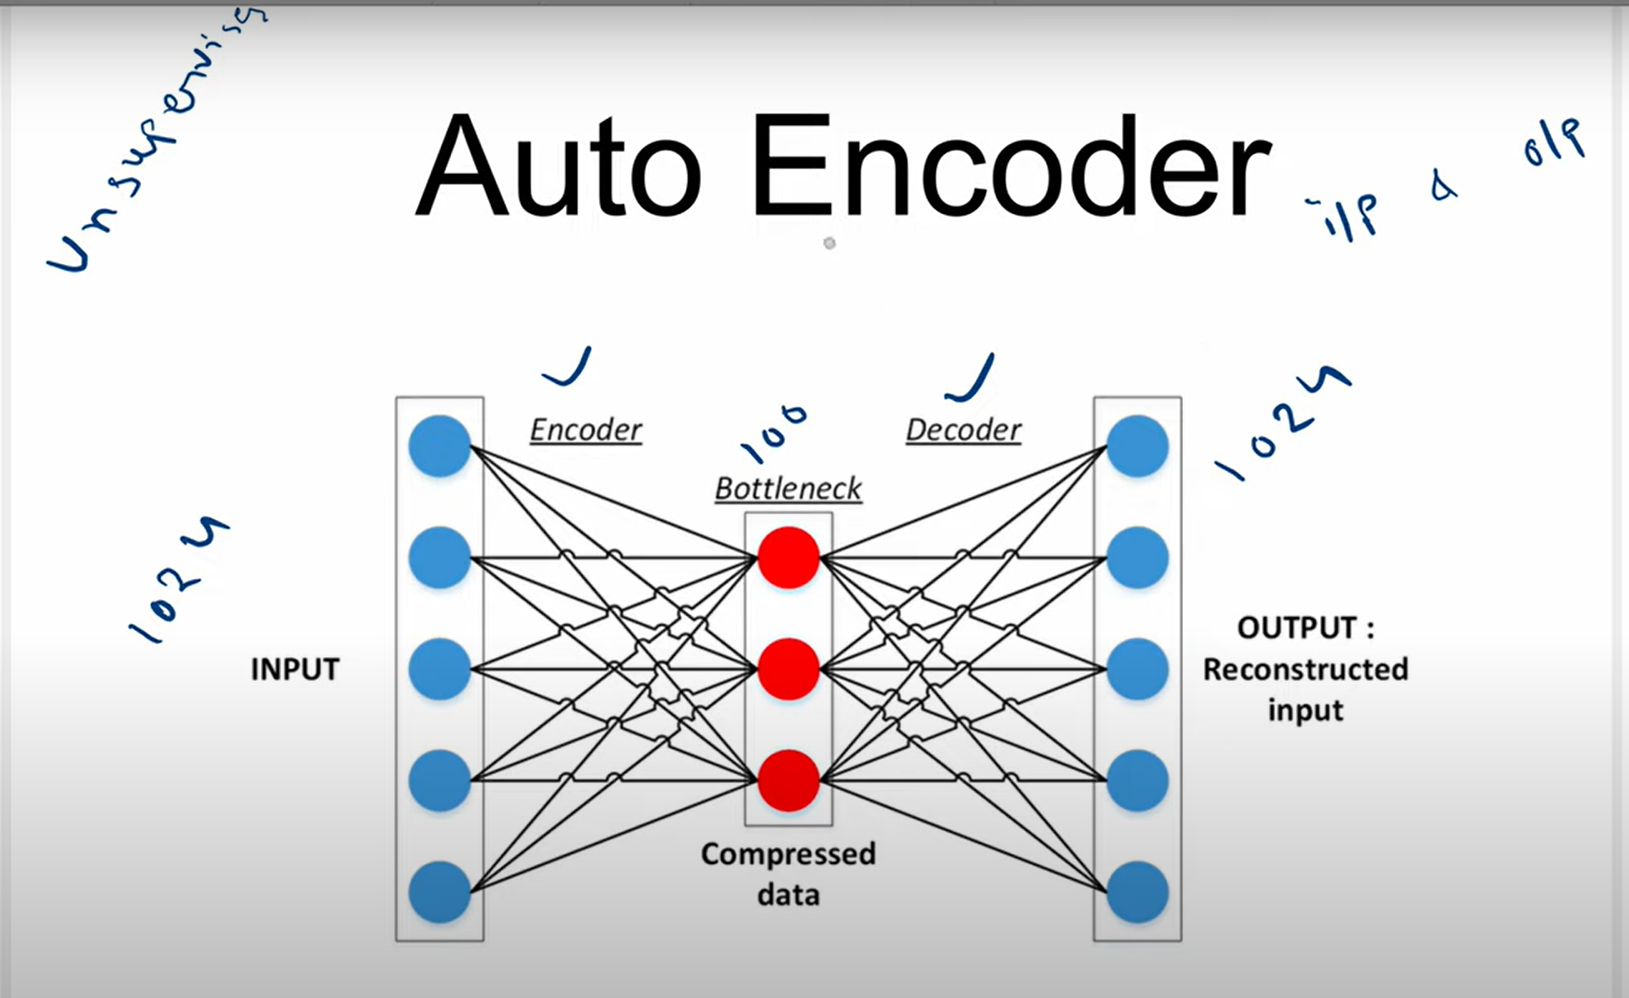

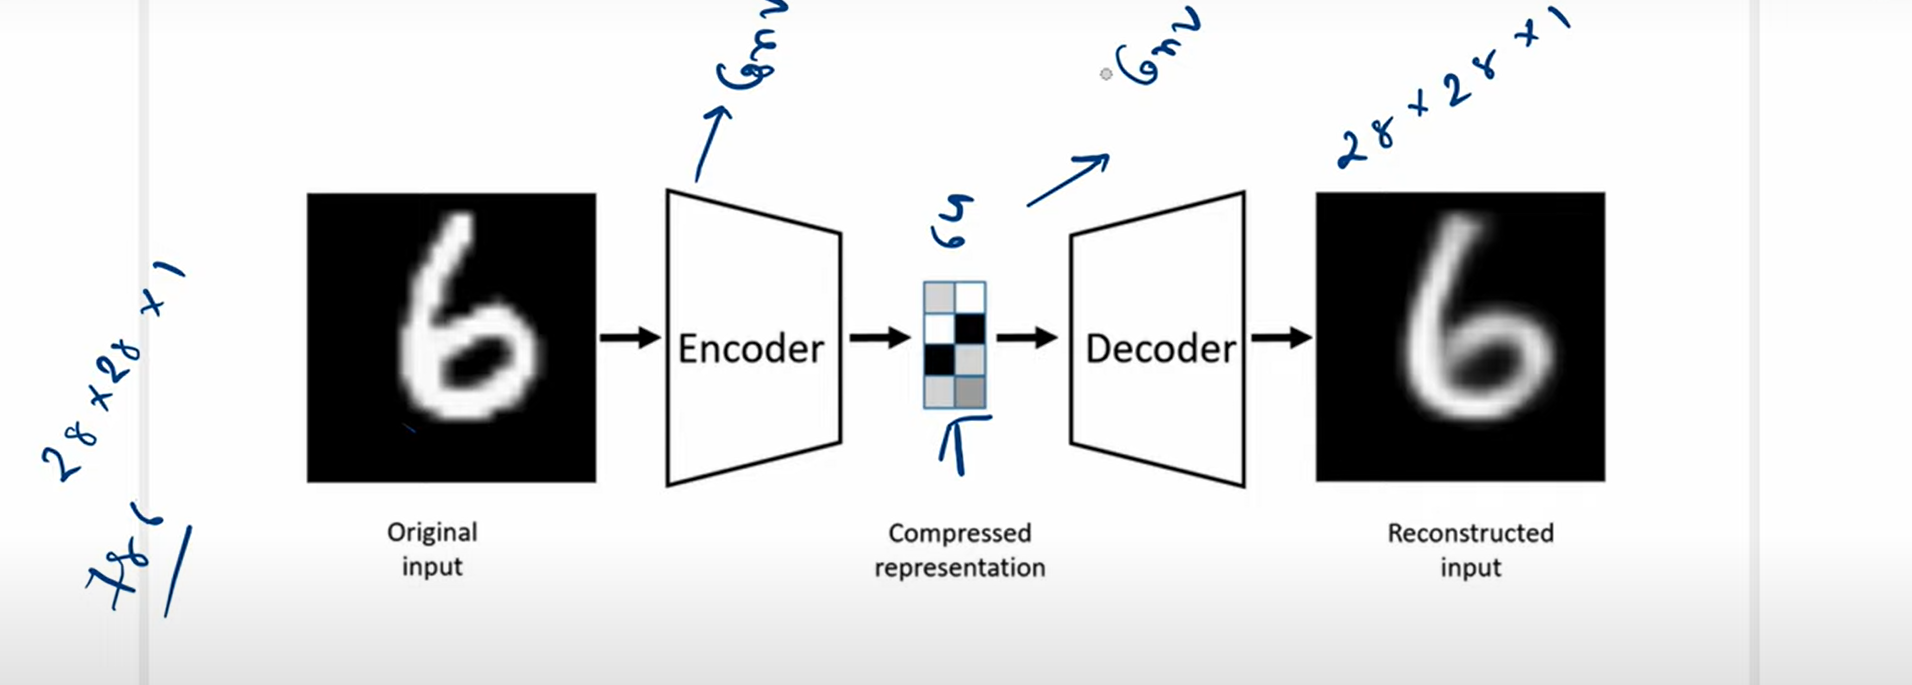

Use Cases:-

1. Dimensionality Reduction

2. Feature Extraction

3. Anamaly Detection

4. Denoising

#Implementation

In [25]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt

In [4]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

In [16]:
batch_size = 32
num_epochs = 2

In [6]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.61MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 57.8kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.6MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [8]:
len(train_data)

60000

In [9]:
image, label = train_data[0]
image.shape

torch.Size([1, 28, 28])

In [10]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1)
    self.activation1 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
    self.activation2 = nn.ReLU()
    self.fc_out = nn.Linear(64 * 7 * 7, 64)

  def forward(self, x):
    x = self.activation1(self.conv1(x)) #32x14x14
    x = self.activation2(self.conv2(x)) #64x7x7
    x = x.flatten(start_dim=1) #3136
    x = self.fc_out(x) #64

    return x

In [11]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.fc_in = nn.Linear(64, 64 * 7 * 7)
    self.convt1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
    self.activation1 = nn.ReLU()
    self.convt2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1)
    self.activation2 = nn.ReLU()
    self.convt3 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1)
    self.activation3 = nn.Sigmoid()

  def forward(self, x):
    x = self.fc_in(x) #3136
    batch_size = x.size(0)
    x = x.view(batch_size, 64, 7, 7) #64x7x7

    x = self.activation1(self.convt1(x)) #64x14x14
    x = self.activation2(self.convt2(x)) #32x28x28
    x = self.activation3(self.convt3(x)) #1x28x28

    return x

In [12]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [19]:
model = AutoEncoder()

In [20]:
optim = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

AutoEncoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (activation1): ReLU()
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (activation2): ReLU()
    (fc_out): Linear(in_features=3136, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (fc_in): Linear(in_features=64, out_features=3136, bias=True)
    (convt1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (activation1): ReLU()
    (convt2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (activation2): ReLU()
    (convt3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation3): Sigmoid()
  )
)

In [21]:
for epoch in range(num_epochs):
  running_loss = 0.0
  for image, label in train_loader:
    image = image.to(device)

    optim.zero_grad()

    output = model(image)
    loss = criterion(image, output)

    loss.backward()
    optim.step()

    running_loss += loss.item()

  print(f'Epoch: {epoch + 1}, Training Loss: {running_loss:.4f}')

Epoch: 1, Training Loss: 34.4483
Epoch: 2, Training Loss: 6.6625


In [24]:
with torch.no_grad():
  running_loss = 0.0
  for image, label in test_loader:
    image = image.to(device)

    output = model(image)
    loss = criterion(image, output)

    running_loss += loss.item()

  print(f'Testing Loss: {running_loss:.4f}')

Testing Loss: 0.8938


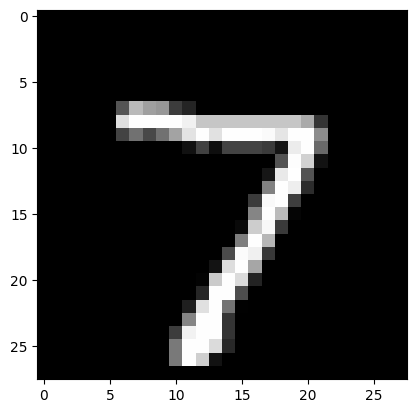

In [29]:
image, label = test_data[0]
image = image.numpy().squeeze()
plt.imshow(image, cmap='gray')

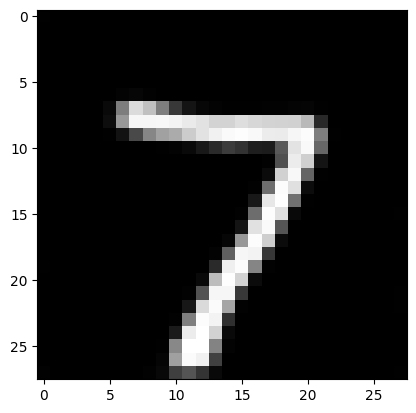

In [31]:
image, label = test_data[0]
image = image.to(device)
image = image.unsqueeze(0)
output = model(image)
output = output.cpu().detach().numpy().squeeze()
plt.imshow(output, cmap='gray')